In [1]:

import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:

# Import the PyTorch library for tensor operations.
import torch

# Import the neural network module from PyTorch.
import torch.nn as nn

# Import functional operations from PyTorch.
import torch.nn.functional as F

# Import the 'numpy' library for numerical operations.
import numpy as np

# Import the 'functools' module for higher-order functions.
import functools

# Import the Adam optimizer from PyTorch.
from torch.optim import Adam

# Import the DataLoader class from PyTorch for handling datasets.
from torch.utils.data import DataLoader

# Import data transformation functions from torchvision.
import torchvision.transforms as transforms

# Import the MNIST dataset from torchvision.
from torchvision.datasets import MNIST

# Import 'tqdm' for creating progress bars during training.
import tqdm

# Import 'trange' and 'tqdm' specifically for notebook compatibility.
from tqdm.notebook import trange, tqdm

# Import the learning rate scheduler from PyTorch.
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

# Import the 'matplotlib.pyplot' library for plotting graphs.
import matplotlib.pyplot as plt

# Import the 'make_grid' function from torchvision.utils for visualizing image grids.
from torchvision.utils import make_grid

# Importing the `rearrange` function from the `einops` library
from einops import rearrange

# Importing the `math` module for mathematical operations
import math


In [3]:

transform = transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.5,), (0.5,))
])


In [4]:

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


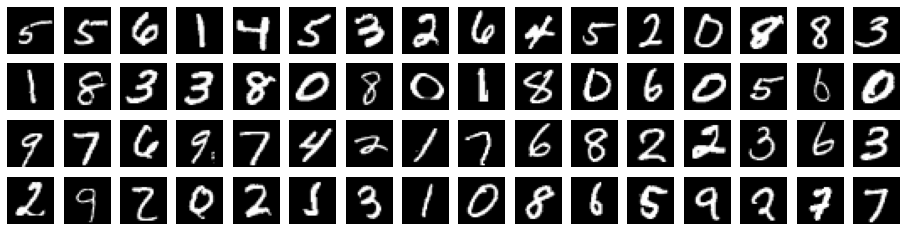

In [5]:

unique_images, unique_labels = next(iter(train_loader))
unique_images = unique_images.numpy()


fig, axes = plt.subplots(4, 16, figsize=(16, 4), sharex=True, sharey=True)  # Create a 4x16 grid of subplots with a wider figure

for i in range(4):  # Loop over rows
    for j in range(16):  # Loop over columns
        index = i * 16 + j  # Calculate the index in the batch
        axes[i, j].imshow(unique_images[index].squeeze(), cmap='gray')  # Show the image using a grayscale colormap
        axes[i, j].axis('off')  # Turn off axis labels and ticks

plt.show()  # Display the plot


In [6]:

# Define a module for Gaussian random features used to encode time steps.
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


In [7]:

# Define a module for a fully connected layer that reshapes outputs to feature maps.
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.


In [8]:

# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        # Additional encoding layers (copied from the original code)
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        # Additional encoding path layers (copied from the original code)
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h


In [9]:

# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        
        print("embed - equal to x in shape?")
        print(embed.shape)
        print("x")
        print(x.shape)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        
        print("h4")
        print(h4.shape)

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        
        print("final h before the return in the Unet")
        print(h.shape)
        return h


In [10]:

# Using GPU
device = "cpu"

# Marginal Probability Standard Deviation Function
def marginal_prob_std(t, sigma):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = torch.tensor(t, device=device)

    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


In [11]:

# Using GPU
device = "cpu"

def diffusion_coeff(t, sigma):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)


In [12]:

# Sigma Value
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)


In [13]:

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.
    """
    # Sample time uniformly in the range (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    
    print("the start ............................")
    
    print("random_t")
    print(random_t.shape)
    
    # Find the noise std at the sampled time `t`
    std = marginal_prob_std(random_t)
    
    print("std")
    print(std.shape)

    # Generate normally distributed noise
    z = torch.randn_like(x)
    
    print("x")
    print(x.shape)
    print("z")
    print(z.shape)
    
    perturbed_x = x 
    print( perturbed_x.shape )
    out_img = perturbed_x[3]
    out_img2=out_img.detach().numpy()
    arr_ = np.squeeze(out_img2)
    plt.imshow(arr_)
    plt.show()
    
    ############################################

    # Perturb the input data with the generated noise
    perturbed_x = x + z * std[:, None, None, None]
    print("perturbed")
    print( perturbed_x.shape )
    out_img = perturbed_x[3]
    out_img2=out_img.detach().numpy()
    arr_ = np.squeeze(out_img2)
    plt.imshow(arr_)
    plt.show()

    # Get the score from the model using the perturbed data and time
    score = model(perturbed_x, random_t)
     
    #############################
    
    print("the loss parameters ...............")
    print("score")
    print( score.shape )
    print("std after expansions std[:, None, None, None]")
    print( std[:, None, None, None].shape )
    print("z")
    print(z.shape)
    
    print("values in score, std, and z......................")
    
    print("vals in score")
    print(score[5, :, 3, :])  ## torch.Size([2048, 1, 28, 28])
    
    print("vals in std")
    print(std[:, None, None, None]) 
    
    print("vals in z")
    print(z[5, :, 3, :]) 
    
    temp_res = score * std[:, None, None, None]
    print("temp_res = score * std[:, None, None, None]")
    print(temp_res.shape)
    
    print("vals in temp_res = score * std[:, None, None, None]")
    print(temp_res[5, :, 3, :]) 
    

    # Calculate the loss based on the score and noise
    loss = torch.mean(
        torch.sum(
            ( score * std[:, None, None, None] + z )**2 , 
            dim=(1, 2, 3)
        )
    )
    print( loss )
    input("blue")

    return loss


In [14]:

# Number of steps
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                            marginal_prob_std,
                            diffusion_coeff,
                            batch_size=64,
                            x_shape=(1, 28, 28),
                            num_steps=num_steps,
                            device='cuda',
                            eps=1e-3, y=None):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - x_shape: The shape of the samples.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    # Do not include any noise in the last sampling step.
    return mean_x


In [15]:

# Define the score-based model and move it to the specified device

score_model = torch.nn.DataParallel( UNet(marginal_prob_std=marginal_prob_std_fn))

score_model = score_model.to(device)


In [16]:

# Number of training epochs
n_epochs = 50
# Size of a mini-batch
batch_size = 2048
# Learning rate
lr = 5e-4


In [17]:

# Load the MNIST dataset and create a data loader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [18]:

# Define the Adam optimizer for training the model
optimizer = Adam(score_model.parameters(), lr=lr)


In [19]:

# Progress bar for epochs
tqdm_epoch = trange(n_epochs)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([2048, 1, 28, 28])
torch.Size([2048])
the start ............................
random_t
torch.Size([2048])
std
torch.Size([2048])
x
torch.Size([2048, 1, 28, 28])
z
torch.Size([2048, 1, 28, 28])
torch.Size([2048, 1, 28, 28])


<ipython-input-10-4c1e076651c1>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


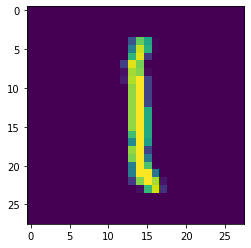

perturbed
torch.Size([2048, 1, 28, 28])


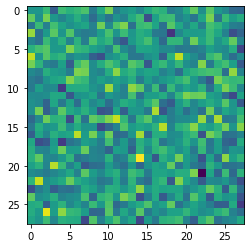

the loss parameters ...............
score
torch.Size([2048, 1, 28, 28])
std after expansions std[:, None, None, None]
torch.Size([2048, 1, 1, 1])
z
torch.Size([2048, 1, 28, 28])
values in score, std, and z......................
vals in score
tensor([[ 0.1153, -0.3472, -0.9118, -0.5990,  0.1857, -0.9457, -0.2787, -1.2579,
          0.0774, -1.0013,  0.2348, -1.1415, -1.0438, -0.1604,  0.2754, -0.1257,
         -0.4799, -0.6419,  1.5998, -0.1888,  1.3123,  0.4183,  1.4619, -0.2109,
          0.3502,  0.1606,  0.7409,  0.2915]], grad_fn=<SliceBackward0>)
vals in std
tensor([[[[3.3404]]],


        [[[8.1028]]],


        [[[4.3078]]],


        ...,


        [[[2.3373]]],


        [[[5.6493]]],


        [[[6.2619]]]])
vals in z
tensor([[-0.1931, -1.5503,  0.8404,  1.2056,  0.1829, -1.8575,  1.2781, -0.8179,
         -1.4384,  0.7285, -0.7350, -0.0721,  0.2089,  1.5230,  0.6307,  0.0916,
          0.8300,  0.1160,  0.6607,  0.9556, -0.3464,  1.5558, -0.7130,  0.7840,
         -0.0725,  

KeyboardInterrupt: Interrupted by user

In [20]:



for epoch in tqdm_epoch:
    avg_loss  = 0.
    num_items = 0
    
    # Iterate through mini-batches in the data loader
    for x, y in tqdm(data_loader):
        
        print( x.shape )
        print( y.shape )
        x = x.to(device)
        # Calculate the loss and perform backpropagation
        
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss for the current epoch
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt.pth')


In [ ]:

# Load the pre-trained checkpoint from disk.
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()
